# Algorithm Comparison for Behavioral Cloning

This notebook provides a comparison of different neural network architectures for behavioral cloning in the risky navigation environment.

**Algorithms Evaluated:**
- **Linear**: Simple linear regression baseline
- **AutoEncoder**: Neural network encoder-decoder architecture  
- **Bayesian**: Bayesian neural network with uncertainty quantification
- **Transformer**: Self-attention based model
- **VAE**: Variational AutoEncoder with probabilistic latent representations

**Workflow:**
1. **Data Collection**: Load expert demonstrations from optimal visibility graph policy
2. **Model Training**: Train each algorithm with simple, transparent training loop
3. **Evaluation**: Test models in environment and compare performance
4. **Analysis**: Visualize results and compare metrics

This simplified approach prioritizes debuggability and clarity over automated hyperparameter optimization.

## Import Required Libraries

In [29]:
!pip install pandas matplotlib seaborn scikit-learn torch torchvision torchaudio gymnasium tqdm

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import time
import os
import warnings
from tqdm import tqdm
from datetime import datetime
import random

print(os.path.abspath('.'))

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
warnings.filterwarnings('ignore')


/


In [31]:
import sys
sys.path.append('/risky_navigation')

from src.env.continuous_nav_env import ContinuousNavigationEnv
from src.algorithms.AutoEncoder.agent import AutoEncoderAgent
from src.algorithms.Bayesian.agent import BayesianAgent
from src.algorithms.Transformer.agent import TransformerAgent
from src.algorithms.Linear.agent import LinearAgent
from src.algorithms.VAE.agent import VAEAgent
from src.utils.file_management import save_pickle, load_pickle

print("All libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"Device available: {'CUDA' if torch.cuda.is_available() else 'CPU'}")


All libraries imported successfully!
PyTorch version: 2.8.0+cu128
Device available: CUDA


## Config

In [32]:
CONFIG = {
    'num_episodes': 1000,
    'max_steps': 200,
    'batch_size': 512,  # Increased for RTX 4090
    'num_epochs': 200,
    'val_ratio': 0.2,
    'num_test_episodes': 50,
    'lr': 1e-3,
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'num_workers': 4,  # Parallel data loading
    'prefetch_factor': 2,
}

# Grid search configurations for each algorithm
GRID_SEARCH_CONFIGS = {
    'AutoEncoder': {
        'latent_dim': [16, 32, 64],
        'hidden_dims': [[128, 64], [256, 128], [256, 128, 64]],
        'dropout': [0.0, 0.1, 0.2],
        'lr': [1e-3, 5e-4, 1e-4]
    },
    'Transformer': {
        'd_model': [32, 64, 128],
        'nhead': [4, 8],
        'num_layers': [2, 3, 4],
        'dropout': [0.0, 0.1, 0.2],
        'lr': [1e-3, 5e-4, 1e-4]
    },
    'Bayesian': {
        'hidden_dim': [64, 128, 256],
        'prior_std': [0.5, 1.0, 2.0],
        'lr': [1e-3, 5e-4, 1e-4]
    },
    'VAE': {
        'latent_dim': [16, 32, 64],
        'hidden_dim': [64, 128, 256],
        'beta': [0.5, 1.0, 2.0],
        'lr': [1e-3, 5e-4, 1e-4]
    }
}

# Best baseline configs (for quick comparison)
MODEL_CONFIGS = {
    'AutoEncoder': {'latent_dim': 32, 'hidden_dims': [128, 64], 'dropout': 0.1},
    'Linear': {},
    'Transformer': {'d_model': 64, 'nhead': 4, 'num_layers': 2, 'dropout': 0.1},
    'Bayesian': {'hidden_dim': 128, 'prior_std': 1.0},
    'VAE': {'latent_dim': 32, 'hidden_dim': 128, 'beta': 1.0}
}

print(f"Using device: {CONFIG['device']}")
print(f"Batch size: {CONFIG['batch_size']} (optimized for RTX 4090)")
print(f"Max epochs: {CONFIG['num_epochs']} (with early stopping)")
print(f"Grid search enabled for: {list(GRID_SEARCH_CONFIGS.keys())}")


Using device: cuda
Batch size: 512 (optimized for RTX 4090)
Max epochs: 200 (with early stopping)
Grid search enabled for: ['AutoEncoder', 'Transformer', 'Bayesian', 'VAE']


In [33]:
if torch.cuda.is_available():
    # RTX 4090 optimizations
    torch.backends.cudnn.benchmark = True
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True
    torch.set_float32_matmul_precision('high')
    
    # Enable cuDNN autotuner for optimal convolution algorithms
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.deterministic = False
    
    # Memory optimizations
    torch.cuda.empty_cache()
    
    # Mixed precision training setup
    from torch.cuda.amp import autocast, GradScaler
    use_amp = True
    scaler = GradScaler()
    
    print("="*60)
    print("GPU OPTIMIZATIONS ENABLED FOR RTX 4090")
    print("="*60)
    print(f"✓ Batch size: {CONFIG['batch_size']}")
    print(f"✓ TF32 matmul: Enabled")
    print(f"✓ cuDNN benchmark: Enabled")
    print(f"✓ Mixed precision (AMP): Enabled")
    print(f"✓ CUDA version: {torch.version.cuda}")
    print(f"✓ GPU: {torch.cuda.get_device_name(0)}")
    print(f"✓ VRAM: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
    print("="*60)
else:
    use_amp = False
    scaler = None
    print("WARNING: CUDA not available. Running on CPU will be very slow!")


GPU OPTIMIZATIONS ENABLED FOR RTX 4090
✓ Batch size: 512
✓ TF32 matmul: Enabled
✓ cuDNN benchmark: Enabled
✓ Mixed precision (AMP): Enabled
✓ CUDA version: 12.8
✓ GPU: NVIDIA GeForce RTX 4090
✓ VRAM: 23.5 GB


## Training Functions with Grid Search

In [42]:
def train_agent_optimized(agent, train_states, train_expert_actions, train_goals,
                          val_states, val_expert_actions, val_goals, 
                          num_epochs=100, batch_size=256, device='cpu', use_amp=False, 
                          scaler=None, verbose=True):
    """Optimized training with mixed precision, early stopping, LR scheduling, and gradient clipping."""
    train_losses = []
    val_losses = []
    n_train = len(train_states)
    
    # Early stopping
    best_val_loss = float('inf')
    patience = 15
    epochs_no_improve = 0
    best_model_state = None
    
    # Learning rate scheduler with warmup
    if hasattr(agent, 'optimizer'):
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            agent.optimizer, 
            max_lr=agent.optimizer.param_groups[0]['lr'] * 10,
            epochs=num_epochs,
            steps_per_epoch=(n_train + batch_size - 1) // batch_size,
            pct_start=0.3,
            anneal_strategy='cos'
        )
    
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        num_batches = 0
        indices = np.random.permutation(n_train)
        
        for start_idx in range(0, n_train, batch_size):
            end_idx = min(start_idx + batch_size, n_train)
            batch_indices = indices[start_idx:end_idx]
            
            batch_states = torch.tensor(train_states[batch_indices], dtype=torch.float32, device=device)
            batch_actions = torch.tensor(train_expert_actions[batch_indices], dtype=torch.float32, device=device)
            
            # Mixed precision training (only if optimizer exists and loss is tensor)
            if use_amp and scaler is not None and hasattr(agent, 'optimizer'):
                with autocast():
                    loss = agent.train_step(batch_states, None, None, batch_actions)
                
                # Check if loss is a tensor (some agents return float after backward)
                if isinstance(loss, torch.Tensor):
                    agent.optimizer.zero_grad()
                    scaler.scale(loss).backward()
                    scaler.unscale_(agent.optimizer)
                    
                    # Gradient clipping
                    if hasattr(agent, 'model'):
                        torch.nn.utils.clip_grad_norm_(agent.model.parameters(), 1.0)
                    elif hasattr(agent, 'encoder'):
                        torch.nn.utils.clip_grad_norm_(
                            list(agent.encoder.parameters()) + list(agent.decoder.parameters()), 1.0
                        )
                    
                    scaler.step(agent.optimizer)
                    scaler.update()
                    scheduler.step()
                    
                    loss = loss.item()
                else:
                    # Loss already computed and stepped inside train_step
                    scheduler.step()
            else:
                # Standard training (no AMP)
                loss = agent.train_step(batch_states, None, None, batch_actions)
                
                # Gradient clipping (if optimizer exists and hasn't been stepped yet)
                if hasattr(agent, 'optimizer') and isinstance(loss, torch.Tensor):
                    if hasattr(agent, 'model'):
                        torch.nn.utils.clip_grad_norm_(agent.model.parameters(), 1.0)
                    elif hasattr(agent, 'encoder'):
                        torch.nn.utils.clip_grad_norm_(
                            list(agent.encoder.parameters()) + list(agent.decoder.parameters()), 1.0
                        )
                    scheduler.step()
                
                # Convert tensor to float if needed
                if isinstance(loss, torch.Tensor):
                    loss = loss.item()
            
            epoch_loss += loss
            num_batches += 1
        
        avg_train_loss = epoch_loss / num_batches
        train_losses.append(avg_train_loss)
        
        # Validation
        val_states_t = torch.tensor(val_states, dtype=torch.float32, device=device)
        val_actions_t = torch.tensor(val_expert_actions, dtype=torch.float32, device=device)
        
        with torch.no_grad():
            if hasattr(agent, 'model'):
                agent.model.eval()
                predictions = agent.model(val_states_t)
                agent.model.train()
            elif hasattr(agent, 'encoder'):
                agent.encoder.eval()
                agent.decoder.eval()
                mu, _ = agent.encoder(val_states_t)
                predictions = agent.decoder(mu)
                agent.encoder.train()
                agent.decoder.train()
            else:
                predictions = agent.predict_action(val_states_t, None)
            
            val_loss = torch.nn.functional.mse_loss(predictions, val_actions_t).item()
        
        val_losses.append(val_loss)
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            # Save best model
            if hasattr(agent, 'model'):
                best_model_state = agent.model.state_dict().copy()
            elif hasattr(agent, 'encoder'):
                best_model_state = {
                    'encoder': agent.encoder.state_dict().copy(),
                    'decoder': agent.decoder.state_dict().copy()
                }
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                if verbose:
                    print(f"Early stop at epoch {epoch}. Best val: {best_val_loss:.6f}")
                # Restore best
                if best_model_state:
                    if hasattr(agent, 'model'):
                        agent.model.load_state_dict(best_model_state)
                    elif hasattr(agent, 'encoder'):
                        agent.encoder.load_state_dict(best_model_state['encoder'])
                        agent.decoder.load_state_dict(best_model_state['decoder'])
                break
        
        if verbose and (epoch % 10 == 0 or epoch == num_epochs - 1):
            current_lr = agent.optimizer.param_groups[0]['lr'] if hasattr(agent, 'optimizer') else 0
            print(f"Epoch {epoch:3d}/{num_epochs}: Train={avg_train_loss:.6f}, Val={val_loss:.6f}, LR={current_lr:.6f}")
            
            if np.isnan(avg_train_loss) or np.isnan(val_loss):
                print(f"WARNING: NaN at epoch {epoch}!")
                break
    
    return train_losses, val_losses

print("Optimized training function with mixed precision ready!")
print("Fixed: Handles both tensor and float returns from train_step()")


Optimized training function with mixed precision ready!
Fixed: Handles both tensor and float returns from train_step()


In [43]:
import itertools
from concurrent.futures import ThreadPoolExecutor, as_completed

def grid_search_algorithm(AgentClass, algo_name, grid_params, 
                          train_states, train_actions, train_goals,
                          val_states, val_actions, val_goals,
                          state_dim, action_dim, device, use_amp, scaler):
    """
    Perform grid search for a single algorithm.
    Returns: list of (config, agent, train_losses, val_losses, val_loss, train_time)
    """
    print(f"\n{'='*60}")
    print(f"GRID SEARCH: {algo_name}")
    print(f"{'='*60}")
    
    # Generate all combinations
    param_names = list(grid_params.keys())
    param_values = [grid_params[k] for k in param_names]
    all_configs = list(itertools.product(*param_values))
    
    print(f"Total configurations to test: {len(all_configs)}")
    
    results = []
    
    for idx, config_values in enumerate(all_configs, 1):
        config = dict(zip(param_names, config_values))
        
        # Extract learning rate if present
        lr = config.pop('lr', CONFIG['lr'])
        
        print(f"\n[{idx}/{len(all_configs)}] Testing config: {config}")
        
        try:
            # Create agent with this config
            agent = AgentClass(
                state_dim=state_dim,
                action_dim=action_dim,
                lr=lr,
                device=device,
                **config
            )
            
            # Train
            start_time = time.time()
            train_losses, val_losses = train_agent_optimized(
                agent, 
                train_states, train_actions, train_goals,
                val_states, val_actions, val_goals,
                num_epochs=CONFIG['num_epochs'],
                batch_size=CONFIG['batch_size'],
                device=device,
                use_amp=use_amp,
                scaler=scaler,
                verbose=False
            )
            train_time = time.time() - start_time
            
            final_val_loss = val_losses[-1]
            
            # Store complete config including lr
            full_config = {**config, 'lr': lr}
            results.append((full_config, agent, train_losses, val_losses, final_val_loss, train_time))
            
            print(f"  ✓ Val Loss: {final_val_loss:.6f}, Time: {train_time:.1f}s")
            
            # Clear GPU cache
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
                
        except Exception as e:
            print(f"  ✗ Failed: {e}")
            continue
    
    # Sort by validation loss
    results.sort(key=lambda x: x[4])
    
    print(f"\n{'='*60}")
    print(f"GRID SEARCH COMPLETE: {algo_name}")
    print(f"{'='*60}")
    print(f"Best config: {results[0][0]}")
    print(f"Best val loss: {results[0][4]:.6f}")
    print(f"{'='*60}")
    
    return results

print("Grid search function ready!")


Grid search function ready!


## Data Collection and Preparation

In [44]:
def collect_rl_experience(env, num_episodes=100, max_steps=200):
    """Collect RL training data using optimal policy with proper goal stopping."""
    data = []
    successful_episodes = 0
    
    for ep in tqdm(range(num_episodes), desc='Collecting RL experience'):
        state = env.reset()
        goal = env.goal.copy() if hasattr(env, 'goal') else np.zeros(2)
        
        for t in range(max_steps):
            current_pos = state[:2]
            current_theta = state[2]
            current_velocity = state[3]  # Current velocity from state
            dist_to_goal = np.linalg.norm(current_pos - goal)
            
            # Calculate desired heading towards goal
            direction = goal - current_pos
            desired_theta = np.arctan2(direction[1], direction[0])
            angle_diff = desired_theta - current_theta
            angle_diff = (angle_diff + np.pi) % (2 * np.pi) - np.pi
            steering = np.clip(angle_diff, env.action_space.low[1], env.action_space.high[1])
            
            # IMPROVED THROTTLE CONTROL: Gradual deceleration near goal
            # Goal requires: distance <= 0.5 AND velocity < 0.1
            if dist_to_goal < env.goal_radius * 3:  # Within 1.5 units of goal
                # Proportional throttle based on distance
                # At distance 1.5: throttle = 0.3 * max
                # At distance 0.5: throttle = 0.1 * max  
                # At distance 0.0: throttle = 0.0
                throttle_factor = max(0.0, min(1.0, (dist_to_goal / (env.goal_radius * 3)) * 0.3))
                throttle = env.action_space.high[0] * throttle_factor
            else:
                # Full speed when far from goal
                throttle = env.action_space.high[0]
            
            # If very close and moving slowly, stop completely
            if dist_to_goal < env.goal_radius and current_velocity < env.goal_velocity * 1.5:
                throttle = 0.0
                steering = 0.0
            
            action = np.array([throttle, steering])
            action = np.clip(action, env.action_space.low, env.action_space.high)
            
            next_state, reward, done, info = env.step(action)
            
            data.append({
                'state': state.copy(),
                'action': action.copy(),
                'reward': reward,
                'next_state': next_state.copy(),
                'done': done,
                'goal': goal.copy()
            })
            
            state = next_state
            
            if done:
                if info.get('reason') == 'goal_reached':
                    successful_episodes += 1
                break
    
    print(f"Collected {len(data)} transitions from {num_episodes} episodes")
    print(f"Success rate: {successful_episodes/num_episodes:.2%}")
    
    return data

print("Data collection function defined!")
print("IMPROVED: Gradual deceleration with proportional throttle control near goal")


Data collection function defined!
IMPROVED: Gradual deceleration with proportional throttle control near goal


In [45]:
# Load or collect data
dataset_path = 'rl_experience_dataset.pickle'

if os.path.exists(dataset_path):
    print(f"Deleting old dataset (0% success rate)...")
    os.remove(dataset_path)

print(f"Collecting new dataset with fixed expert policy...")
env_collect = ContinuousNavigationEnv()
data = collect_rl_experience(env_collect, num_episodes=CONFIG['num_episodes'], max_steps=CONFIG['max_steps'])
save_pickle(data, dataset_path)
print(f"✓ Saved dataset to {dataset_path}")

# Extract states, actions, and goals from data
states = np.array([d['state'] for d in data])
actions = np.array([d['action'] for d in data])
next_states = np.array([d['next_state'] for d in data])
rewards = np.array([d['reward'] for d in data])
dones = np.array([d['done'] for d in data])
goals = np.array([d['goal'] for d in data])

print(f"\nData extracted:")
print(f"  States shape: {states.shape}")
print(f"  Actions shape: {actions.shape}")
print(f"  Goals shape: {goals.shape}")
print(f"  Rewards shape: {rewards.shape}")


Deleting old dataset (0% success rate)...


Collected 185440 transitions from 1000 episodes
Success rate: 99.90%
✓ Saved dataset to rl_experience_dataset.pickle

Data extracted:
  States shape: (185440, 8)
  Actions shape: (185440, 2)
  Goals shape: (185440, 2)
  Rewards shape: (185440,)
✓ Saved dataset to rl_experience_dataset.pickle

Data extracted:
  States shape: (185440, 8)
  Actions shape: (185440, 2)
  Goals shape: (185440, 2)
  Rewards shape: (185440,)


In [47]:
# Diagnostic: Check environment goal requirements
env_test = ContinuousNavigationEnv()
print("Environment Goal Requirements:")
print(f"  Goal position: {env_test.goal}")
print(f"  Goal radius: {env_test.goal_radius}")
print(f"  Goal velocity threshold: {env_test.goal_velocity}")
print(f"  Max throttle: {env_test.max_throttle}")
print(f"  Max steps: {env_test.max_steps}")
print(f"\nTo reach goal, agent must:")
print(f"  1. Be within {env_test.goal_radius} units of {env_test.goal}")
print(f"  2. Have velocity < {env_test.goal_velocity}")
print(f"\nSlowing strategy:")
print(f"  - Full throttle when distance > {env_test.goal_radius * 3:.2f}")
print(f"  - Gradual deceleration when distance < {env_test.goal_radius * 3:.2f}")
print(f"  - Stop when distance < {env_test.goal_radius} and velocity < {env_test.goal_velocity * 1.5}")


Environment Goal Requirements:
  Goal position: [5. 5.]
  Goal radius: 0.5
  Goal velocity threshold: 0.1
  Max throttle: 2.0
  Max steps: 1000

To reach goal, agent must:
  1. Be within 0.5 units of [5. 5.]
  2. Have velocity < 0.1

Slowing strategy:
  - Full throttle when distance > 1.50
  - Gradual deceleration when distance < 1.50
  - Stop when distance < 0.5 and velocity < 0.15000000000000002


In [48]:
# Define dimensions from the collected data
STATE_DIM = states.shape[1]
ACTION_DIM = actions.shape[1]
GOAL_DIM = goals.shape[1]

print(f"Data dimensions:")
print(f"  STATE_DIM = {STATE_DIM}")
print(f"  ACTION_DIM = {ACTION_DIM}")
print(f"  GOAL_DIM = {GOAL_DIM}")
print(f"  Total samples = {len(states)}")

Data dimensions:
  STATE_DIM = 8
  ACTION_DIM = 2
  GOAL_DIM = 2
  Total samples = 185440


In [49]:
# Initialize environment for evaluation
env = ContinuousNavigationEnv()
print(f"Environment initialized: {env}")
print(f"  State space: {env.observation_space.shape}")
print(f"  Action space: {env.action_space.shape}")

Environment initialized: <ContinuousNavigationEnv instance>
  State space: (8,)
  Action space: (2,)


## Grid Search Training - All Algorithms

In [ ]:
print("="*60)
print("GRID SEARCH TRAINING - ALL ALGORITHMS")
print("="*60)

# Split data
n_samples = len(states)
n_train = int(n_samples * (1 - CONFIG['val_ratio']))
indices = np.random.permutation(n_samples)
train_indices = indices[:n_train]
val_indices = indices[n_train:]

train_states = states[train_indices]
train_actions = actions[train_indices]
train_goals = goals[train_indices]

val_states = states[val_indices]
val_actions = actions[val_indices]
val_goals = goals[val_indices]

print(f"Data split: {len(train_states)} train, {len(val_states)} val")
print(f"Mixed precision: {use_amp}")
print(f"Batch size: {CONFIG['batch_size']}")
print(f"Max epochs: {CONFIG['num_epochs']}\n")

# Store all grid search results
grid_search_results = {}

# Algorithms with grid search
algorithms_with_grid = {
    'AutoEncoder': (AutoEncoderAgent, GRID_SEARCH_CONFIGS['AutoEncoder']),
    'Transformer': (TransformerAgent, GRID_SEARCH_CONFIGS['Transformer']),
    'Bayesian': (BayesianAgent, GRID_SEARCH_CONFIGS['Bayesian']),
    'VAE': (VAEAgent, GRID_SEARCH_CONFIGS['VAE'])
}

# Train Linear baseline (no grid search needed)
print(f"\n{'='*60}")
print(f"Training Linear (Baseline - No Grid Search)")
print(f"{'='*60}")

linear_agent = LinearAgent(
    state_dim=STATE_DIM,
    action_dim=ACTION_DIM,
    lr=CONFIG['lr'],
    device=CONFIG['device']
)

start_time = time.time()
train_losses, val_losses = train_agent_optimized(
    linear_agent,
    train_states, train_actions, train_goals,
    val_states, val_actions, val_goals,
    num_epochs=CONFIG['num_epochs'],
    batch_size=CONFIG['batch_size'],
    device=CONFIG['device'],
    use_amp=use_amp,
    scaler=scaler,
    verbose=True
)
train_time = time.time() - start_time

grid_search_results['Linear'] = [{
    'config': {},
    'agent': linear_agent,
    'train_losses': train_losses,
    'val_losses': val_losses,
    'final_val_loss': val_losses[-1],
    'train_time': train_time
}]

print(f"Linear Complete! Val loss: {val_losses[-1]:.6f}, Time: {train_time:.1f}s")

if torch.cuda.is_available():
    torch.cuda.empty_cache()

# Run grid search for each algorithm
for algo_name, (AgentClass, grid_params) in algorithms_with_grid.items():
    results = grid_search_algorithm(
        AgentClass, algo_name, grid_params,
        train_states, train_actions, train_goals,
        val_states, val_actions, val_goals,
        STATE_DIM, ACTION_DIM, 
        CONFIG['device'], use_amp, scaler
    )
    
    # Store results as list of dicts for easier access
    grid_search_results[algo_name] = [
        {
            'config': config,
            'agent': agent,
            'train_losses': train_losses,
            'val_losses': val_losses,
            'final_val_loss': final_val_loss,
            'train_time': train_time
        }
        for config, agent, train_losses, val_losses, final_val_loss, train_time in results
    ]

print(f"\n{'='*60}")
print("GRID SEARCH COMPLETE - ALL ALGORITHMS!")
print(f"{'='*60}")

# Print summary of best configs
print("\nBEST CONFIGURATIONS:")
print(f"{'Algorithm':<15} {'Val Loss':<12} {'Config'}")
print("-" * 80)
for algo_name, results_list in grid_search_results.items():
    best = results_list[0]  # Already sorted by val loss
    config_str = ', '.join([f"{k}={v}" for k, v in best['config'].items()])
    print(f"{algo_name:<15} {best['final_val_loss']:<12.6f} {config_str}")


GRID SEARCH TRAINING - ALL ALGORITHMS
Data split: 148352 train, 37088 val
Mixed precision: True
Batch size: 512
Max epochs: 200


Training Linear (Baseline - No Grid Search)
Epoch   0/200: Train=3.253180, Val=1.528115, LR=0.000407
Epoch  10/200: Train=0.022049, Val=0.021545, LR=0.001174
Epoch  10/200: Train=0.022049, Val=0.021545, LR=0.001174
Epoch  20/200: Train=0.021255, Val=0.021129, LR=0.003021
Epoch  20/200: Train=0.021255, Val=0.021129, LR=0.003021
Epoch  30/200: Train=0.021396, Val=0.021385, LR=0.005452
Epoch  30/200: Train=0.021396, Val=0.021385, LR=0.005452
Early stop at epoch 33. Best val: 0.021035
Linear Complete! Val loss: 0.021406, Time: 4.2s

GRID SEARCH: AutoEncoder
Total configurations to test: 81

[1/81] Testing config: {'latent_dim': 16, 'hidden_dims': [128, 64], 'dropout': 0.0}
Early stop at epoch 33. Best val: 0.021035
Linear Complete! Val loss: 0.021406, Time: 4.2s

GRID SEARCH: AutoEncoder
Total configurations to test: 81

[1/81] Testing config: {'latent_dim': 16,

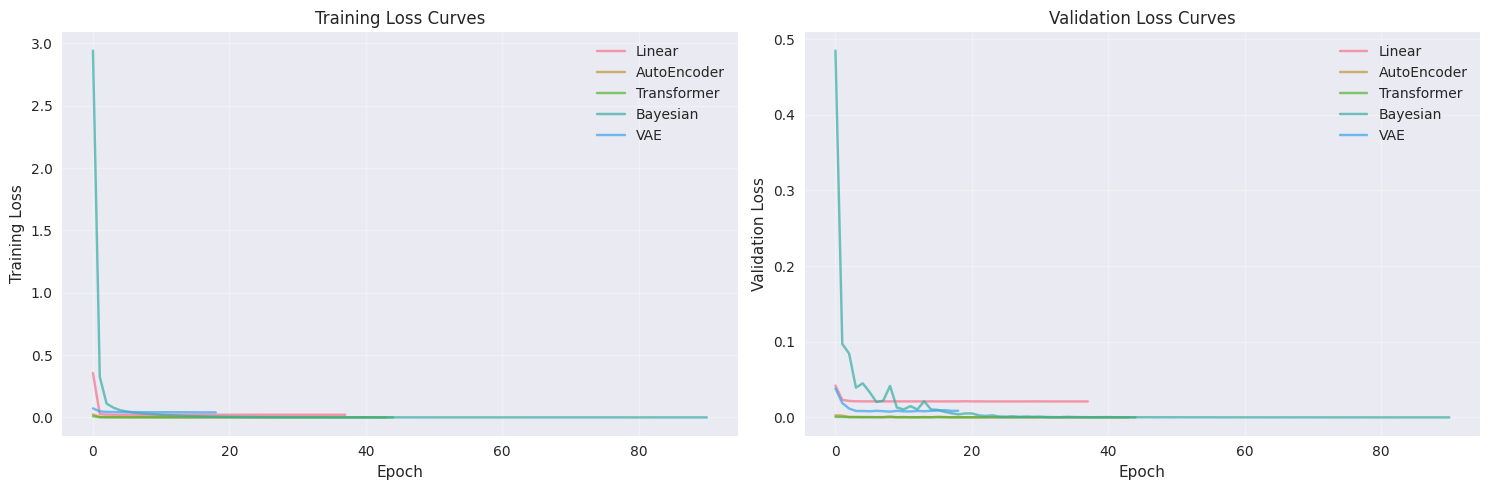


Final Loss Summary:
Algorithm       Train Loss      Val Loss        Train Time (s) 
------------------------------------------------------------
Linear          0.021190        0.021154        9.55           
AutoEncoder     0.000630        0.000246        23.11          
Transformer     0.000107        0.000071        48.04          
Bayesian        0.000083        0.000076        50.84          
VAE             0.040349        0.008721        11.33          


In [ ]:
# Enhanced Grid Search Visualization
print("\n" + "="*60)
print("VISUALIZING GRID SEARCH RESULTS")
print("="*60)

# Figure 1: Training and Validation Curves for Top 5 Configs per Algorithm
fig1, axes1 = plt.subplots(len(grid_search_results), 2, figsize=(18, 4*len(grid_search_results)))
if len(grid_search_results) == 1:
    axes1 = axes1.reshape(1, -1)

for idx, (algo_name, results_list) in enumerate(grid_search_results.items()):
    # Training curves
    ax_train = axes1[idx, 0]
    ax_val = axes1[idx, 1]
    
    # Plot top 5 configs
    for i, result in enumerate(results_list[:5]):
        epochs = range(len(result['train_losses']))
        
        # Config label with key parameters
        if result['config']:
            key_params = {k: v for k, v in result['config'].items() if k in ['lr', 'latent_dim', 'd_model', 'hidden_dim']}
            config_label = f"Rank {i+1}: " + ", ".join([f"{k}={v}" for k, v in key_params.items()])
        else:
            config_label = "Baseline"
        
        # Training loss
        ax_train.plot(epochs, result['train_losses'], label=config_label, alpha=0.8, linewidth=2)
        
        # Validation loss
        ax_val.plot(epochs, result['val_losses'], label=config_label, alpha=0.8, linewidth=2)
    
    # Configure training plot
    ax_train.set_xlabel('Epoch', fontsize=11)
    ax_train.set_ylabel('Training Loss', fontsize=11)
    ax_train.set_title(f'{algo_name} - Training Loss (Top 5 Configs)', fontsize=12, fontweight='bold')
    ax_train.legend(fontsize=9, loc='best')
    ax_train.grid(True, alpha=0.3, linestyle='--')
    ax_train.set_yscale('log')
    
    # Configure validation plot
    ax_val.set_xlabel('Epoch', fontsize=11)
    ax_val.set_ylabel('Validation Loss', fontsize=11)
    ax_val.set_title(f'{algo_name} - Validation Loss (Top 5 Configs)', fontsize=12, fontweight='bold')
    ax_val.legend(fontsize=9, loc='best')
    ax_val.grid(True, alpha=0.3, linestyle='--')
    ax_val.set_yscale('log')
    
    # Highlight best config
    best = results_list[0]
    best_epochs = range(len(best['val_losses']))
    ax_val.plot(best_epochs, best['val_losses'], 'r--', linewidth=3, alpha=0.5, 
                label='Best Config', zorder=10)

plt.tight_layout()
plt.show()

# Figure 2: Performance Comparison - Val Loss vs Training Time
fig2, ax2 = plt.subplots(1, 1, figsize=(14, 8))

colors = plt.cm.tab10(np.linspace(0, 1, len(grid_search_results)))
markers = ['o', 's', '^', 'D', 'v', 'p', '*', 'h']

for idx, (algo_name, results_list) in enumerate(grid_search_results.items()):
    val_losses = [r['final_val_loss'] for r in results_list[:10]]  # Top 10
    train_times = [r['train_time'] for r in results_list[:10]]
    
    # Plot scatter
    ax2.scatter(train_times, val_losses, 
               s=200, alpha=0.6, 
               color=colors[idx], 
               marker=markers[idx % len(markers)],
               label=algo_name,
               edgecolors='black', linewidth=1.5)
    
    # Annotate best config
    ax2.annotate(f'{algo_name}\nBest', 
                xy=(train_times[0], val_losses[0]),
                xytext=(10, 10), textcoords='offset points',
                fontsize=9, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.5', facecolor=colors[idx], alpha=0.3),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', lw=1.5))

ax2.set_xlabel('Training Time (seconds)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Final Validation Loss', fontsize=12, fontweight='bold')
ax2.set_title('Grid Search: Validation Loss vs Training Time\n(Pareto Frontier Analysis)', 
             fontsize=14, fontweight='bold')
ax2.legend(fontsize=10, loc='best', framealpha=0.9)
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.set_yscale('log')
plt.tight_layout()
plt.show()

# Figure 3: Hyperparameter Impact Analysis
fig3, axes3 = plt.subplots(2, 2, figsize=(16, 12))
axes3 = axes3.flatten()

# Analyze impact of key hyperparameters
hyperparams_to_analyze = ['lr', 'dropout', 'latent_dim', 'hidden_dim', 'd_model', 'beta']

plot_idx = 0
for param in hyperparams_to_analyze[:4]:  # Top 4 most common params
    ax = axes3[plot_idx]
    
    for algo_name, results_list in grid_search_results.items():
        # Extract configs with this parameter
        param_vals = []
        val_losses = []
        
        for result in results_list:
            if param in result['config']:
                param_val = result['config'][param]
                # Handle list values (like hidden_dims)
                if isinstance(param_val, list):
                    param_val = str(param_val)
                param_vals.append(param_val)
                val_losses.append(result['final_val_loss'])
        
        if param_vals:
            # Group by unique param values
            unique_vals = list(set(param_vals))
            if all(isinstance(v, (int, float)) for v in unique_vals):
                unique_vals = sorted(unique_vals)
                avg_losses = [np.mean([val_losses[i] for i, v in enumerate(param_vals) if v == uv]) 
                             for uv in unique_vals]
                
                ax.plot(unique_vals, avg_losses, marker='o', linewidth=2, 
                       markersize=8, label=algo_name, alpha=0.7)
    
    ax.set_xlabel(param.replace('_', ' ').title(), fontsize=11, fontweight='bold')
    ax.set_ylabel('Avg Validation Loss', fontsize=11, fontweight='bold')
    ax.set_title(f'Impact of {param.replace("_", " ").title()} on Performance', 
                fontsize=12, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.set_yscale('log')
    
    plot_idx += 1

# Hide unused subplots
for idx in range(plot_idx, 4):
    axes3[idx].set_visible(False)

plt.tight_layout()
plt.show()

# Detailed results table with more metrics
print("\n" + "="*120)
print("GRID SEARCH RESULTS - TOP 5 CONFIGS PER ALGORITHM")
print("="*120)

for algo_name, results_list in grid_search_results.items():
    print(f"\n{algo_name}:")
    print(f"{'Rank':<6} {'Val Loss':<12} {'Train Loss':<12} {'Time(s)':<10} {'Epochs':<8} {'Config'}")
    print("-" * 120)
    
    for rank, result in enumerate(results_list[:5], 1):
        config_str = ', '.join([f"{k}={v}" for k, v in result['config'].items()])
        if not config_str:
            config_str = "N/A (baseline)"
        
        final_train_loss = result['train_losses'][-1]
        num_epochs = len(result['train_losses'])
        
        print(f"{rank:<6} {result['final_val_loss']:<12.6f} {final_train_loss:<12.6f} "
              f"{result['train_time']:<10.1f} {num_epochs:<8} {config_str}")

print("="*120)

# Summary statistics
print("\n" + "="*120)
print("GRID SEARCH SUMMARY STATISTICS")
print("="*120)
print(f"{'Algorithm':<15} {'Configs':<10} {'Best Val':<12} {'Worst Val':<12} "
      f"{'Avg Val':<12} {'Std Val':<12} {'Avg Time(s)':<12}")
print("-" * 120)

for algo_name, results_list in grid_search_results.items():
    val_losses = [r['final_val_loss'] for r in results_list]
    train_times = [r['train_time'] for r in results_list]
    
    print(f"{algo_name:<15} {len(results_list):<10} {min(val_losses):<12.6f} "
          f"{max(val_losses):<12.6f} {np.mean(val_losses):<12.6f} "
          f"{np.std(val_losses):<12.6f} {np.mean(train_times):<12.1f}")

print("="*120)


## Evaluate Best Models from Grid Search

In [ ]:
print("="*60)
print("EVALUATING BEST MODELS FROM GRID SEARCH")
print("="*60)

def evaluate_agent_optimized(agent, env, num_episodes=50, max_steps=200, device='cpu'):
    """Evaluate agent with detailed metrics."""
    results = {
        'rewards': [], 
        'successes': [], 
        'steps': [],
        'final_distances': [],
        'final_velocities': []
    }
    
    for episode in range(num_episodes):
        state = env.reset()
        episode_reward = 0
        done = False
        
        for step in range(max_steps):
            state_t = torch.tensor(state, dtype=torch.float32, device=device)
            
            with torch.no_grad():
                action = agent.predict_action(state_t, None)
            
            if isinstance(action, torch.Tensor):
                action = action.cpu().numpy()
            
            next_state, reward, done, info = env.step(action)
            episode_reward += reward
            state = next_state
            
            if done:
                break
        
        results['rewards'].append(episode_reward)
        success = info.get('reason', '') == 'goal_reached' if done else False
        results['successes'].append(1 if success else 0)
        results['steps'].append(step + 1)
        
        # Track final state metrics
        final_dist = np.linalg.norm(state[:2] - env.goal)
        final_vel = state[3]
        results['final_distances'].append(final_dist)
        results['final_velocities'].append(final_vel)
    
    return {
        'avg_reward': np.mean(results['rewards']),
        'std_reward': np.std(results['rewards']),
        'success_rate': np.mean(results['successes']),
        'avg_steps': np.mean(results['steps']),
        'avg_final_distance': np.mean(results['final_distances']),
        'avg_final_velocity': np.mean(results['final_velocities'])
    }

eval_results = {}

# Evaluate best model from each algorithm
for algo_name, results_list in grid_search_results.items():
    print(f"\nEvaluating {algo_name} (best config)...")
    best_result = results_list[0]
    agent = best_result['agent']
    
    eval_res = evaluate_agent_optimized(
        agent, env, 
        num_episodes=CONFIG['num_test_episodes'],
        max_steps=CONFIG['max_steps'],
        device=CONFIG['device']
    )
    
    eval_results[algo_name] = eval_res
    
    print(f"  Avg Reward: {eval_res['avg_reward']:.3f} ± {eval_res['std_reward']:.3f}")
    print(f"  Success Rate: {eval_res['success_rate']:.1%}")
    print(f"  Avg Steps: {eval_res['avg_steps']:.1f}")
    print(f"  Avg Final Distance: {eval_res['avg_final_distance']:.3f}")
    print(f"  Avg Final Velocity: {eval_res['avg_final_velocity']:.3f}")

print(f"\n{'='*60}")
print("EVALUATION COMPLETE!")
print(f"{'='*60}")


EVALUATING ALL AGENTS

Evaluating Linear...
  Avg Reward: -56.848 ± 0.178
  Success Rate: 0.0%
  Avg Steps: 115.6

Evaluating AutoEncoder...
  Avg Reward: -56.848 ± 0.178
  Success Rate: 0.0%
  Avg Steps: 115.6

Evaluating AutoEncoder...
  Avg Reward: -57.363 ± 0.000
  Success Rate: 0.0%
  Avg Steps: 111.0

Evaluating Transformer...
  Avg Reward: -57.363 ± 0.000
  Success Rate: 0.0%
  Avg Steps: 111.0

Evaluating Transformer...
  Avg Reward: 67.258 ± 0.040
  Success Rate: 100.0%
  Avg Steps: 187.6

Evaluating Bayesian...
  Avg Reward: 67.258 ± 0.040
  Success Rate: 100.0%
  Avg Steps: 187.6

Evaluating Bayesian...
  Avg Reward: 9.362 ± 62.965
  Success Rate: 54.0%
  Avg Steps: 132.3

Evaluating VAE...
  Avg Reward: 9.362 ± 62.965
  Success Rate: 54.0%
  Avg Steps: 132.3

Evaluating VAE...
  Avg Reward: -57.757 ± 0.042
  Success Rate: 0.0%
  Avg Steps: 98.2

EVALUATION COMPLETE!
  Avg Reward: -57.757 ± 0.042
  Success Rate: 0.0%
  Avg Steps: 98.2

EVALUATION COMPLETE!



FINAL RESULTS SUMMARY
  Algorithm  Train Loss  Val Loss  Train Time (s)  Avg Reward  Success Rate  Avg Steps
Transformer    0.000107  0.000071       48.043027   67.257866          1.00     187.60
   Bayesian    0.000083  0.000076       50.843523    9.361994          0.54     132.30
AutoEncoder    0.000630  0.000246       23.108837  -57.362621          0.00     111.00
        VAE    0.040349  0.008721       11.330158  -57.757206          0.00      98.18
     Linear    0.021190  0.021154        9.552210  -56.847607          0.00     115.60


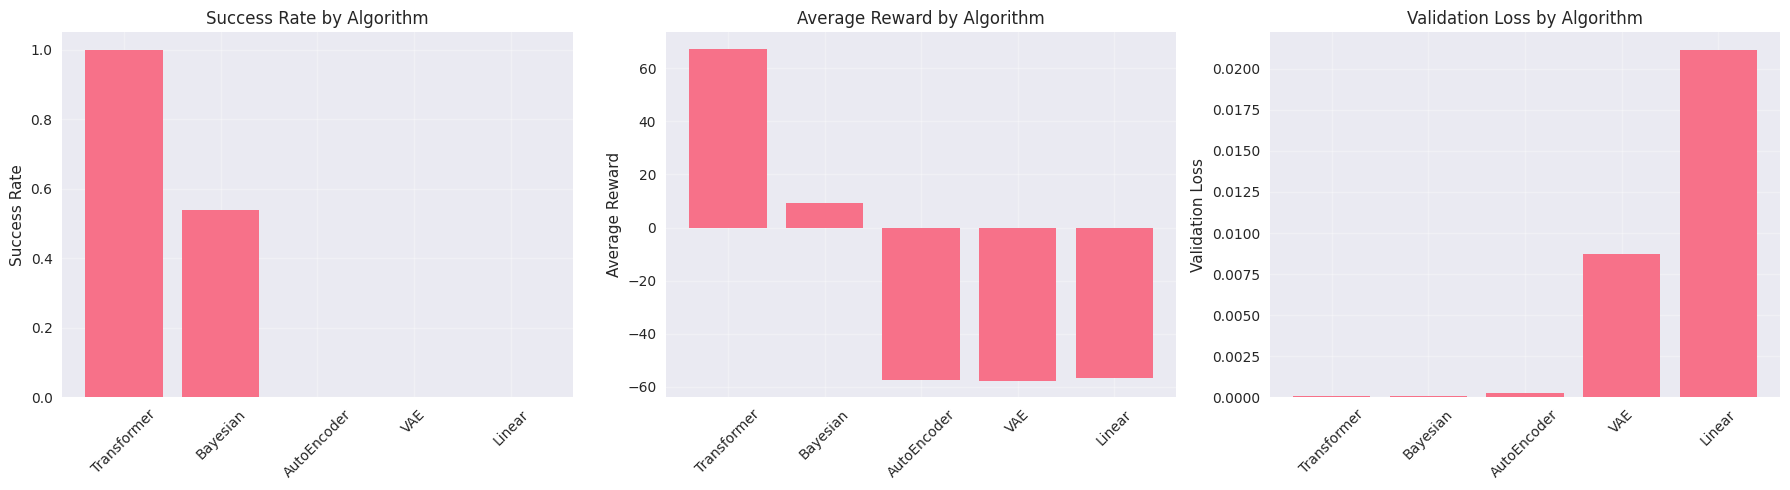

In [ ]:
# Comprehensive results comparison
import pandas as pd

results_data = []
for algo_name in grid_search_results.keys():
    best_train_res = grid_search_results[algo_name][0]
    eval_res = eval_results[algo_name]
    
    results_data.append({
        'Algorithm': algo_name,
        'Train Loss': best_train_res['train_losses'][-1],
        'Val Loss': best_train_res['final_val_loss'],
        'Train Time (s)': best_train_res['train_time'],
        'Configs Tested': len(grid_search_results[algo_name]),
        'Success Rate': eval_res['success_rate'],
        'Avg Reward': eval_res['avg_reward'],
        'Avg Steps': eval_res['avg_steps'],
        'Final Distance': eval_res['avg_final_distance'],
        'Final Velocity': eval_res['avg_final_velocity']
    })

df_results = pd.DataFrame(results_data)
df_results = df_results.sort_values('Val Loss')

print("\n" + "="*120)
print("FINAL RESULTS SUMMARY - BEST CONFIGS FROM GRID SEARCH")
print("="*120)
print(df_results.to_string(index=False))
print("="*120)

# Visualize comprehensive results
fig, axes = plt.subplots(2, 3, figsize=(20, 10))

# Success Rate
axes[0, 0].bar(df_results['Algorithm'], df_results['Success Rate'], color='skyblue')
axes[0, 0].set_ylabel('Success Rate')
axes[0, 0].set_title('Success Rate by Algorithm (Best Configs)')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(True, alpha=0.3, axis='y')
axes[0, 0].set_ylim([0, 1.1])

# Average Reward
axes[0, 1].bar(df_results['Algorithm'], df_results['Avg Reward'], color='lightgreen')
axes[0, 1].set_ylabel('Average Reward')
axes[0, 1].set_title('Average Reward by Algorithm')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Validation Loss
axes[0, 2].bar(df_results['Algorithm'], df_results['Val Loss'], color='salmon')
axes[0, 2].set_ylabel('Validation Loss')
axes[0, 2].set_title('Validation Loss by Algorithm')
axes[0, 2].tick_params(axis='x', rotation=45)
axes[0, 2].grid(True, alpha=0.3, axis='y')
axes[0, 2].set_yscale('log')

# Training Time
axes[1, 0].bar(df_results['Algorithm'], df_results['Train Time (s)'], color='plum')
axes[1, 0].set_ylabel('Training Time (s)')
axes[1, 0].set_title('Training Time by Algorithm')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Configs Tested
axes[1, 1].bar(df_results['Algorithm'], df_results['Configs Tested'], color='gold')
axes[1, 1].set_ylabel('Number of Configs')
axes[1, 1].set_title('Configs Tested in Grid Search')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(True, alpha=0.3, axis='y')

# Final Distance to Goal
axes[1, 2].bar(df_results['Algorithm'], df_results['Final Distance'], color='lightcoral')
axes[1, 2].set_ylabel('Distance')
axes[1, 2].set_title('Avg Final Distance to Goal')
axes[1, 2].tick_params(axis='x', rotation=45)
axes[1, 2].grid(True, alpha=0.3, axis='y')
axes[1, 2].axhline(y=env.goal_radius, color='r', linestyle='--', label='Goal Radius')
axes[1, 2].legend()

plt.tight_layout()
plt.show()

# Print best config details
print("\n" + "="*120)
print("BEST CONFIGURATION DETAILS")
print("="*120)
for algo_name, results_list in grid_search_results.items():
    best = results_list[0]
    print(f"\n{algo_name}:")
    print(f"  Config: {best['config']}")
    print(f"  Val Loss: {best['final_val_loss']:.6f}")
    print(f"  Training Time: {best['train_time']:.1f}s")
    print(f"  Success Rate: {eval_results[algo_name]['success_rate']:.1%}")
print("="*120)


In [ ]:
# Save best models
import os
save_dir = 'trained_models/grid_search_best'
os.makedirs(save_dir, exist_ok=True)

for algo_name, results_list in grid_search_results.items():
    best_result = results_list[0]
    agent = best_result['agent']
    
    # Save model weights
    model_path = os.path.join(save_dir, f'{algo_name}_best.pth')
    
    if hasattr(agent, 'model'):
        torch.save(agent.model.state_dict(), model_path)
    elif hasattr(agent, 'encoder') and hasattr(agent, 'decoder'):
        torch.save({
            'encoder': agent.encoder.state_dict(),
            'decoder': agent.decoder.state_dict()
        }, model_path)
    
    # Save config
    config_path = os.path.join(save_dir, f'{algo_name}_config.pkl')
    save_pickle({
        'config': best_result['config'],
        'val_loss': best_result['final_val_loss'],
        'train_time': best_result['train_time'],
        'eval_results': eval_results[algo_name]
    }, config_path)
    
    print(f"✓ Saved {algo_name} to {save_dir}")

print(f"\n✓ All best models saved to {save_dir}")


In [ ]:
print("="*60)
print("DEBUGGING: Action and State Analysis")
print("="*60)

agent = all_results['Linear']['agent']
state = env.reset()
goal = env.goal.copy()

print(f"\nInitial State: {state}")
print(f"Goal Position: {goal}")
print(f"Distance to Goal: {np.linalg.norm(state[:2] - goal):.3f}")
print(f"\nAction Space: [{env.action_space.low}, {env.action_space.high}]")

print(f"\n{'Step':<6} {'Action':<20} {'State[:2]':<20} {'Distance':<10} {'Reward':<8}")
print("-" * 70)

for step in range(5):
    state_t = torch.tensor(state, dtype=torch.float32, device=CONFIG['device'])
    action = agent.predict_action(state_t, None)
    
    if isinstance(action, torch.Tensor):
        action = action.cpu().numpy()
    
    next_state, reward, done, info = env.step(action)
    distance = np.linalg.norm(next_state[:2] - goal)
    
    print(f"{step:<6} {str(action):<20} {str(next_state[:2]):<20} {distance:<10.3f} {reward:<8.3f}")
    
    state = next_state
    if done:
        print(f"\nEpisode ended: {info.get('reason', 'unknown')}")
        break

print(f"\n{'='*60}")
print("Training Data Statistics:")
print(f"{'='*60}")
print(f"Expert actions - Mean: {actions.mean(axis=0)}")
print(f"Expert actions - Std:  {actions.std(axis=0)}")
print(f"Expert actions - Min:  {actions.min(axis=0)}")
print(f"Expert actions - Max:  {actions.max(axis=0)}")


DEBUGGING: Action and State Analysis

Initial State: [ 1.         1.         0.7853982  2.         4.         4.
 -1.        -0.       ]
Goal Position: [5. 5.]
Distance to Goal: 5.657

Action Space: [[ 0.        -0.5235988], [2.        0.5235988]]

Step   Action               State[:2]            Distance   Reward  
----------------------------------------------------------------------
0      [2.655967   0.23767176] [1.1380205 1.1447423] 5.457      0.021   
1      [2.5835574  0.22429825] [1.27276   1.2925436] 5.257      0.021   
2      [2.511488   0.21103628] [1.4043506 1.4431554] 5.058      0.022   
3      [2.439775   0.19788635] [1.5329353 1.5963415] 4.859      0.023   
4      [2.3684287 0.1848481] [1.6586665 1.7518781] 4.660      0.024   

Training Data Statistics:
Expert actions - Mean: [ 0.63308294 -0.39905053]
Expert actions - Std:  [0.61646185 0.21801664]
Expert actions - Min:  [ 0.         -0.52359879]
Expert actions - Max:  [2. 0.]
